In [1]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD import *
from MDPD.readers import *
from MDPD import utils
import matplotlib.pyplot as plt
import matplotlib

----
## Read Data

In [2]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/bird'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'bluebird_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'bluebird_truth.txt'))
lock = np.zeros(train.shape[1:])

2018-04-01 13:41:52,162 : INFO : The Data has 39 dimensions, 108 samples, and 2 volcabulary size.


In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/dog'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'dog_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'dog_truth.txt'))


In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/rte'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'rte_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'rte_truth.txt'))
lock = np.zeros(train.shape[1:])
lock[:, -1] = 1

In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/trec'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'trec_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'trec_truth.txt'))

In [2]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/web'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'web_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'web_truth.txt'))
lock = np.zeros(train.shape[1:])
lock[:, -1] = 1

2018-03-30 14:24:51,500 : INFO : Data has missing values. A new label is created to represent the missing values.
2018-03-30 14:24:51,521 : INFO : The Data has 177 dimensions, 2665 samples, and 6 volcabulary size.


---
## Analysis

### Original Mutual Information Residue

In [3]:
# Original mutual information residue (G score)
score = MDPD.utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
dim = train.shape[1]
print np.sum(score) / (dim * (dim-1))

0.03756253829869128


MDPD/utils.py:158: RuntimeWarning: divide by zero encountered in log
  pmi = second * (np.log(second) - logfirst)
MDPD/utils.py:158: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (np.log(second) - logfirst)


In [ ]:
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, )

In [44]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(label,2)

/home/vzhao/.virtualenvs/tf/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [48]:
score, weighted = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True)

In [49]:
ss = score.sum(axis=1) * weighted[np.newaxis, :]

In [50]:
ss.shape

(39, 2)

array([16,  7, 29, 34, 26, 24,  0, 31, 11,  8, 36, 37, 15, 19, 28, 21, 18,
       38,  4, 14, 20,  2, 23, 35,  1, 30, 13, 32, 27, 22, 12,  9, 25, 33,
        6, 17,  3, 10,  5])

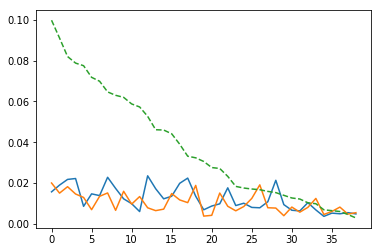

In [56]:
plt.plot(ss[features,0]/38)
plt.plot(ss[features,1]/38)
plt.plot(score/38, '--')
features

### Reference G Statistics

In [4]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * train.shape[0]) for x in percentages]

print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.05252253115807579, 0.03617929584838508, 0.028941614033195937, 0.019020115442742205, 0.01095358279803397]


### Mixture Model with Feature Selection Performance

#### Feature Ranking

array([16,  7, 29, 34, 26, 24,  0, 31, 11,  8, 36, 37, 15, 19, 28, 21, 18,
       38,  4, 14, 20,  2, 23, 35,  1, 30, 13, 32, 27, 22, 12,  9, 25, 33,
        6, 17,  3, 10,  5])

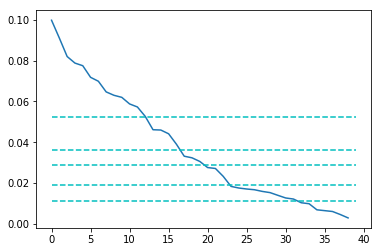

In [51]:
features, score = utils.Feature_Selection.MI_feature_ranking(train)
plt.plot(score/(train.shape[1]-1))
# plot reference G statistics
for foo in percentiles:
    plt.plot([0, len(score)], [foo, foo], 'c--')
features

#### Accuracy and Mutual Information Residue

In [ ]:
Ntop = 9

In [6]:
# Feature Selection
model = MDPD.MDPD()
model.fit(train, ncomp=5, init='majority', verbose=False, features=features[:Ntop], niter=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train, lock)

2018-04-01 13:42:28,988 : INFO : Training an MDPD with dimension 9, sample size 108, vocab size 2 and the target number of components 5
MDPD/utils.py:75: RuntimeWarning: divide by zero encountered in log
  log_votes = np.log(votes)
2018-04-01 13:42:29,023 : INFO : ACCURACY: 89.81%
MDPD/utils.py:228: RuntimeWarning: divide by zero encountered in log
  pmi = second * (np.log(second) - log_first)
MDPD/utils.py:228: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (np.log(second) - log_first)
2018-04-01 13:42:29,041 : INFO : The mutual information residue is 0.0149997481751
2018-04-01 13:42:29,043 : INFO : The mutual information residue of the feature set is 0.012632982449


In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

### Vanilla Model Performance
#### Accuracy

In [7]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD()
model_basic.fit(train, ncomp=4, init='majority', verbose=False, niter=50, lock=lock)
model_basic.accuracy(train, label)

2018-03-30 14:29:52,170 : INFO : Training an MDPD with dimension 177, sample size 2665, vocab size 6 and the target number of components 4
MDPD/MDPD.py:234: RuntimeWarning: divide by zero encountered in log
  log_margin_prob = np.log(data_selected.sum(axis=0) / data_selected.shape[0])
2018-03-30 14:30:21,893 : INFO : ACCURACY: 82.66%


0.8266416510318949

#### Mutual Information Residue

In [8]:
model_basic.MI_residue(train, lock)
# MI residue conditional on the features (although basic model is using all features to learn the model)
features, score = utils.Feature_Selection.MI_feature_ranking(train)
features = np.array(features)
log_post = model_basic.log_posterior(train)
score, weights = utils.Feature_Selection.MI_score_conditional(train,log_post,rm_diag=True, lock=lock)
score_selected = score[features[:Ntop, np.newaxis], features[:Ntop]]
print 'MI residue conditional on the features (although basic model is using all features to learn the model)'
print np.sum(score_selected.sum(axis=(0,1)) * weights) / (Ntop * (Ntop - 1))

2018-03-30 16:14:55,787 : INFO : The mutual information residue is 0.00073482327462
2018-03-30 16:14:55,789 : INFO : The mutual information residue of the feature set is 0.00073482327462


MI residue conditional on the features (although basic model is using all features to learn the model)
-0.006733611156566834


### 

In [57]:
from tensorflow.examples.tutorials.mnist import input_data

In [58]:
mnist = input_data.read_data_sets("/media/vzhao/Data/MNIST/", one_hot=True)

Extracting /media/vzhao/Data/MNIST/train-images-idx3-ubyte.gz
Extracting /media/vzhao/Data/MNIST/train-labels-idx1-ubyte.gz
Extracting /media/vzhao/Data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /media/vzhao/Data/MNIST/t10k-labels-idx1-ubyte.gz


In [59]:
mnist.train.

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fe5d2067e90>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fe57625bdd0>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fe57625bd90>)